# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 2 - Classification with MLP



**Harvard University**<br/>
**Spring 2019**<br/>
**Instructors**: Mark Glickman and Pavlos Protopapas 


<hr style="height:2pt">

In [7]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.

- This homework can be submitted in pairs.

- If you submit individually but you have worked with someone, please include the name of your **one** partner below.
- Please restart the kernel and run the entire notebook again before you submit.

**Names of person you have worked with goes here:**
<br><BR>

###  Use only the libraries below:

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt 
from itertools import chain

from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import Callback, ModelCheckpoint, History, EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
# from keras.optimizers import SGD, Adam
from keras import optimizers
from keras.utils import np_utils
from keras import optimizers
from keras.layers import Dropout
from keras import backend as K
from sklearn.pipeline import Pipeline


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix

import seaborn as sns
sns.set()

%matplotlib inline

<div class='exercise'><b> Question 3: Generalizing Models for Galaxy Classification </b></div>

In this problem, you will revisit the task of classifying galaxies based on visual morphology. You will deploy the model you built in Question 1 on a new, much larger sky survey. In this new data set, which for now we will assume it represents the true Universe, only a small number of observations have been labeled. Your goal is to estimate the proportion of elliptical galaxies in the Universe.
<br><br>**Note** There are multiple *correct* answers to these questions. What we are looking for is a scientific approach to support your arguments with empirical evidences or first principles. 

<span class='sub-q'> 3.1 </span> Use the model you built in Question 1 to estimate the proportion of ellipticall galaxies. Is this estimate trust worthy? Why or why not? 

<span class='sub-q'> 3.2 </span> The performance of classifier will perform differently on this new data set than it does on the data the model was trained (and tested on) in question 1. This is a common occurance in machine learning. Identify and eliminate at least one likely cause of this performance difference in the data. 

(***Hint:*** perform some exploratory data analysis on the new data and compare the features distributions of the data set in question 1 and of the data in this question)

<span class='sub-q'> 3.3 (Implementation not required) </span>  Based on your observations, propose a method to produce an accurate estimate of the proportion of elliptical galaxies in the new data set, support your proposal with results from data analysis and concepts from data science. 

# BRING BACK TRIANED MODEL FROM Q1.5

### Pull back training data, testing data, clean/normalize, etc. to re-train original model

In [9]:
# Read in original galaxy data
galaxy_df = pd.read_csv('data/galaxy_morphology_labeled.csv')
galaxy_df.head()

# Cefine binary classification for full dataset
galaxy_df["binary_class"] = galaxy_df["class"].apply(lambda x: 1 if x == "elliptical" else 0)

# Split source data into train/test
train, test = train_test_split(galaxy_df, test_size=.3, random_state=42)

# Create lb and ub to filter extreme values (+/- std*2.5)
lb, ub = (train["green_color"].mean()-2.5*train["green_color"].std(),
          train["green_color"].mean()+2.5*train["green_color"].std())

# Keep only rows within range
train = train.loc[(train["green_color"] > lb) &
                  (train["green_color"] < ub),]
test = test.loc[(test["green_color"] > lb) &
                (test["green_color"] < ub),]

# Specify features on which to classify (excluding label related columns)
orig_features = [col for col in train.columns \
                 if col not in ["number_of_votes",
                                "probability_elliptical",
                                "probability_spiral",
                                "probability_unknown",
                                "probability_merger",
                                "class", 
                                "binary_class"]]      

# Engineer new feature for green-red
# Engineer new feature for red-infrared
# Perform same engineering to test as train
train["g_r_diff"] = train["green_color"]-train["red_color"]
train["r_i_diff"] = train["red_color"]-train["infrared_color"]
test["g_r_diff"] = test["green_color"]-test["red_color"]
test["r_i_diff"] = test["red_color"]-test["infrared_color"]

# Define engineered feature list
eng_features = ["g_r_diff", "r_i_diff"]

# Define x & y for train and test
x_train = train[orig_features+eng_features]
y_train = train["binary_class"]
x_test = test[orig_features+eng_features]
y_test = test["binary_class"]

# Convert x into scaled numpy array (using same Scaler on test as on train)
scaler = StandardScaler().fit(x_train.astype(np.float64))
x_train_scaled = scaler.transform(x_train.astype(np.float64))
x_test_scaled = scaler.transform(x_test.astype(np.float64))

# Convert y into categorial for Keras
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

# Define ratio of of non-ellip to ellip
# Use this ratio to give more weight in loss function
# to the underweighted (elliptical) class
count_elliptical = train[train["binary_class"]==1].green_color.count()
count_non_elliptical = train[train["binary_class"]==0].green_color.count()
re_weight_ratio = count_non_elliptical / count_elliptical

# Create sample_weight array to tell loss function to give more penalty for ellipticals
sample_weight = train["binary_class"].apply(lambda x: 1 if x == 0 else re_weight_ratio).values

### Re-train original model on original galaxy data just to be complete

In [10]:
# Define fixed hyperparameters
batch_size = 1024
epochs=50
learning_rate = 0.01
decay = 0.005

# Build the model
input_dim = x_train_scaled.shape[1]

model = Sequential()
model.add(Dense(40, activation="relu", kernel_initializer="normal", input_dim = input_dim))
model.add(Dense(30, activation="relu", kernel_initializer="normal"))
model.add(Dense(25, activation="relu", kernel_initializer="normal"))
model.add(Dense(20, activation="relu", kernel_initializer="normal"))
model.add(Dense(15, activation="relu", kernel_initializer="normal"))
model.add(Dense(10, activation="relu", kernel_initializer="normal"))
model.add(Dense(5, activation="relu", kernel_initializer="normal"))
model.add(Dropout(0.2))
model.add(Dense(units=2, kernel_initializer="normal", activation="sigmoid"))
print(model.summary())

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=learning_rate,
                                        beta_1=.9,
                                        beta_2=.999,
                                        decay=decay,
                                        amsgrad=False),
              metrics=["accuracy"])
    
# Set callbacks to early stop and save best model
callbacks = [EarlyStopping(monitor="val_loss", patience=4),
             ModelCheckpoint(filepath="best_model", 
                             monitor="val_loss", 
                             save_best_only=True)]

# Fit the model with sample weightings
model_history = model.fit(x_train_scaled, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          verbose=0,
                          sample_weight=sample_weight,
                          validation_data=(x_test_scaled, y_test))

# Just for completeness, print final scores and calculate r2
score = model.evaluate(x_test_scaled, y_test, verbose=0)
print(f"Test Loss = {score[0]}.")
print(f"Test Accuracy = {score[1]}.")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 40)                440       
_________________________________________________________________
dense_10 (Dense)             (None, 30)                1230      
_________________________________________________________________
dense_11 (Dense)             (None, 25)                775       
_________________________________________________________________
dense_12 (Dense)             (None, 20)                520       
_________________________________________________________________
dense_13 (Dense)             (None, 15)                315       
_________________________________________________________________
dense_14 (Dense)             (None, 10)                160       
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 55        
__________

In [11]:
# Print portion of test data that is elliptical
n_test_e = test[test["binary_class"]==1].green_color.count()
n_test_non_e = test[test["binary_class"]==0].green_color.count()
print(f"% Ellip in Galaxy Test= {(n_test_e/(n_test_non_e+n_test_e)):3.2}")

% Ellip in Galaxy Test= 0.37


In [12]:
# Create predictions from galaxy test data
predictions = model.predict(x_test_scaled)
predictions_df = pd.DataFrame(predictions, columns = ["prob_0", "prob_1"])
predictions_df["Elliptical"] = predictions_df["prob_1"].apply(lambda x: 1 if x > .5 else 0)

# Print portion of test data predicted to be elliptical
n_predict_e = predictions_df[predictions_df["Elliptical"]==1].Elliptical.count()
n_predict_non_e = predictions_df[predictions_df["Elliptical"]==0].Elliptical.count()
print(f"% Ellip Predicted in Galaxy Test= {(n_predict_e/(n_predict_e+n_predict_non_e)):3.2}")

% Ellip Predicted in Galaxy Test= 1.0


# Q3.1:  NOW RE-USE TRAINED MODEL WITH NEW UNIVERSE DATA

In [7]:
universe_df = pd.read_csv('data/galaxy_morphology_semi_labeled.csv')
universe_df.head()

,green_color,red_color,infrared_color,de_vaucouleurs_fit_axial_ratio,exponential_fit_axial_ratio,exponential_disc_fit_log_likelihood,de_vaucouleurs_fit_log_likelihood,star_log_likelihood,number_of_votes,probability_elliptical,probability_spiral,probability_unknown,probability_merger,class
0,20.597660,19.763248,19.377018,0.890790,0.887719,-365.51312,-10296.39500,-69448.500,NaN,NaN,NaN,NaN,NaN,NaN
1,16.068602,14.275770,13.406208,0.846962,0.583541,-12756.09600,-32272.31200,-203823.920,NaN,NaN,NaN,NaN,NaN,NaN
2,25.601834,23.291614,24.511544,0.699872,0.749809,-86.31708,-227.30617,-1036.990,NaN,NaN,NaN,NaN,NaN,NaN
3,22.686954,20.837614,20.032396,0.705292,0.655978,-8858.64400,-1597.61410,-38869.620,NaN,NaN,NaN,NaN,NaN,NaN
4,20.464190,19.271786,18.617180,0.470536,0.424177,-1635.48885,-11248.65150,-83958.805,NaN,NaN,NaN,NaN,NaN,NaN


### Drop NA from universe data

In [8]:
# Check for na values
r0 = universe_df.shape[0]
r1 = universe_df.dropna().shape[0]
print(f"universe_df appears to have {r0-r1} rows with NA values in a column.")

universe_df appears to have 42317 rows with NA values in a column.


### Enhance universe data with extra engineered columns

In [9]:
# Engineer new feature for green-red
# Engineer new feature for green-infrared
universe_df["g_r_diff"] = universe_df["green_color"]-universe_df["red_color"]
universe_df["r_i_diff"] = universe_df["red_color"]-universe_df["infrared_color"]

### Scale universe data using standard scaler FROM TRAINING

In [10]:
# Create DF with just features
x_universe = universe_df[orig_features+eng_features] 

# Convert x into scaled numpy array using original scaler from training
x_universe_scaled = scaler.transform(x_universe.astype(np.float64))

### Use pre-trained model with new universe data to predict

In [11]:
# Create predictions from new universe data using model trained on galaxy data
predictions = model.predict(x_universe_scaled)
predictions_df = pd.DataFrame(predictions, columns = ["prob_0", "prob_1"])
predictions_df["Elliptical"] = predictions_df["prob_1"].apply(lambda x: 1 if x > .5 else 0)

# Print portion of universe data predicted to be elliptical
n_predict_e = predictions_df[predictions_df["Elliptical"]==1].Elliptical.count()
n_predict_non_e = predictions_df[predictions_df["Elliptical"]==0].Elliptical.count()
print(f"% Ellip Predicted in Universe= {(n_predict_e/(n_predict_e+n_predict_non_e)):3.2}")

% Ellip Predicted in Universe= 0.98


### Comparing Distribution of Features Data in Galaxy and Universe

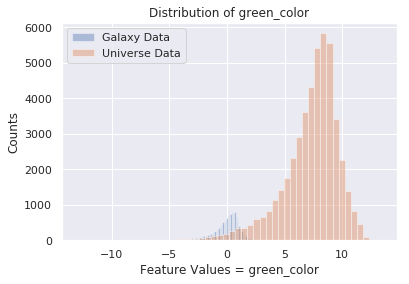

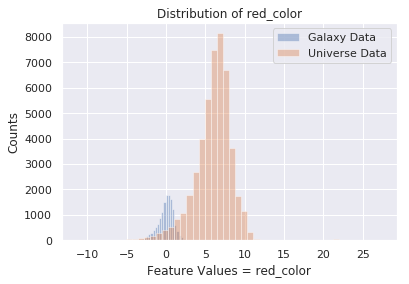

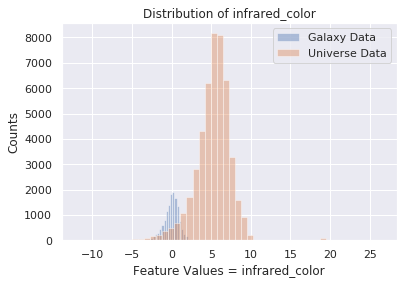

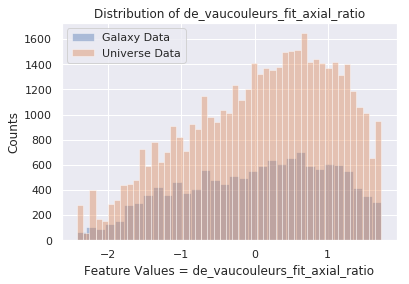

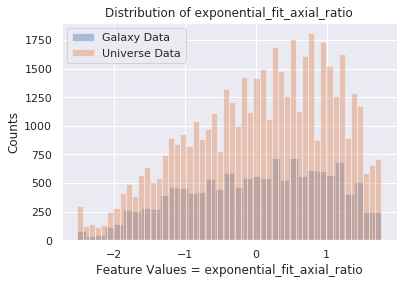

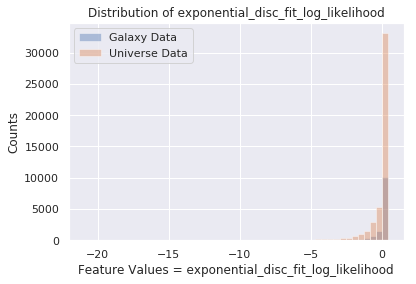

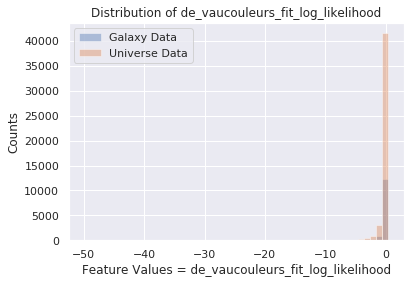

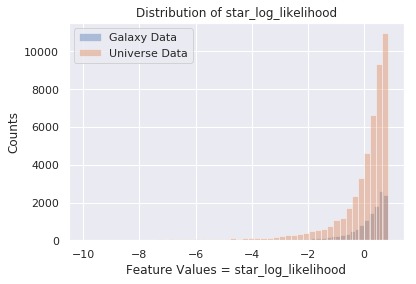

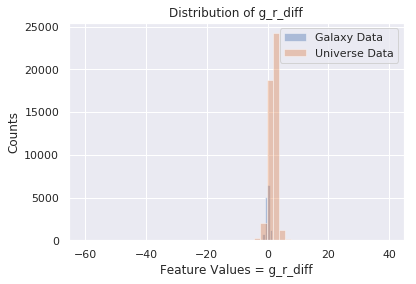

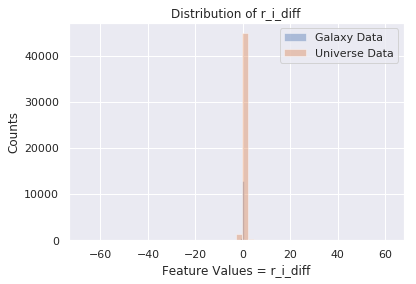

In [12]:
# Show distribution of values for each feature galaxy vs. universe
for i, feature in enumerate(orig_features+eng_features):
    xg = x_train_scaled[:,i]
    xu = x_universe_scaled[:,i]
    
    # Plot histogram
    fig, ax = plt.subplots()
    sns.distplot(xg, label = "Galaxy Data", kde=False, ax=ax)
    sns.distplot(xu, label = "Universe Data", kde=False, ax=ax)
    plt.xlabel(f"Feature Values = {feature}")
    plt.ylabel("Counts")
    plt.title(f"Distribution of {feature}")
    plt.legend()

**STUDENT COMMENTARY:**

- The percentage of ellipticals in the universe (as predicted by the model trained on galaxy data) is very high (e..g, 99%) while the galaxy test data and predictions showed around .37.
- While it is possible the galaxy data happens to have a small percentage of ellipticals while the universe is almost all ellipticals, there is probably another reason for the universe predictions leading to so many ellipticals:  
    - **As the diagrams show above**, the universe data (even after being scaled with the same scaler used for training and test data in the galaxy modeling) has features with data with very different means and standard deviations.
    - Predicting with the galaxy trained model uses weightings that learned from training data that "looks" very different from the new universe data.  This makes the model's predictive abilities dubious.


# Q3.2:  MAKE 1 CORRECTION TO IMPROVE PERFORMANCE

### Eliminate data with red_color/green_color in universe data more 2.5 sd beyond mean of galaxy data

In [13]:
# Make small_universe as copy of full universe before we start dropping rows
small_universe_df = universe_df

# Drop universe data with color feature values 2.5 std from mean of galaxy values
for feature in ["red_color", "green_color"]:
    lb, ub = (train[feature].mean()-2.5*train[feature].std(),
              train[feature].mean()+2.5*train[feature].std())
    
    
    # Keep only rows within range
    small_universe_df = small_universe_df.loc[(small_universe_df[feature] > lb) &
                                              (small_universe_df[feature] < ub),]

# Create DF with just features
x_small_universe = small_universe_df[orig_features+eng_features] 

# Convert x into scaled numpy array using original scaler from training
x_small_universe_scaled = scaler.transform(x_small_universe.astype(np.float64))

### Comparing Distribution of Features Data in Galaxy and Universe (after dropping rows)

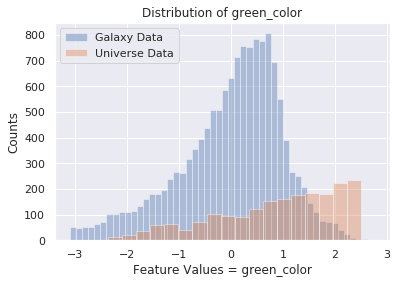

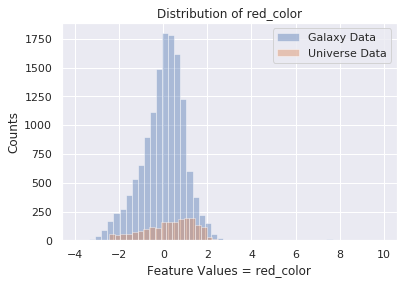

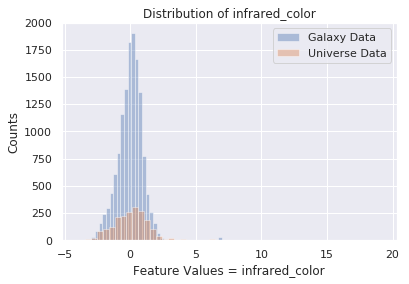

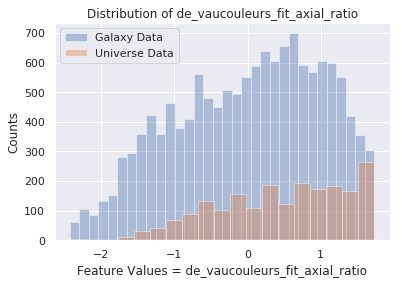

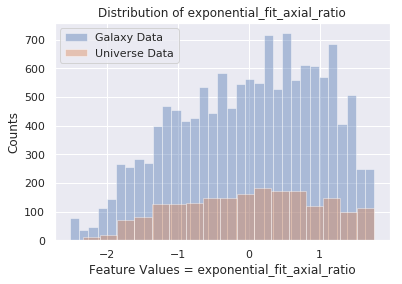

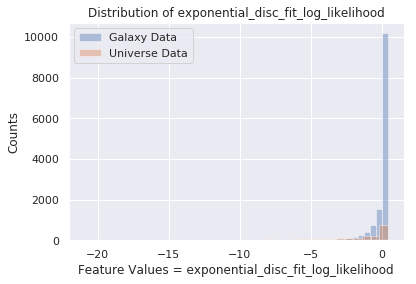

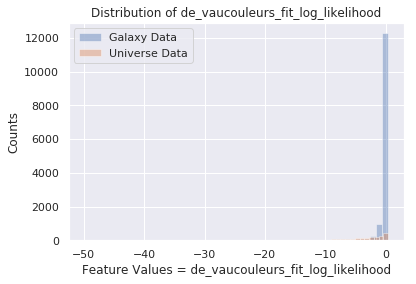

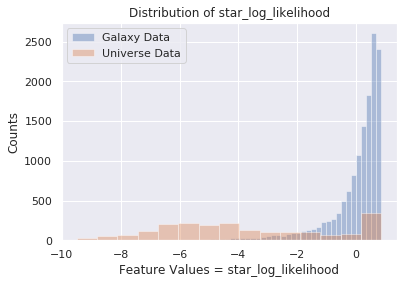

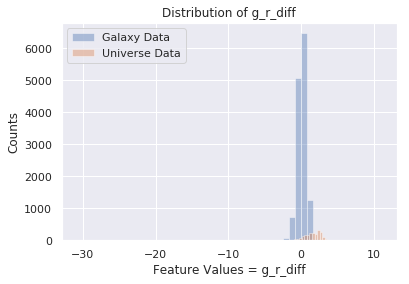

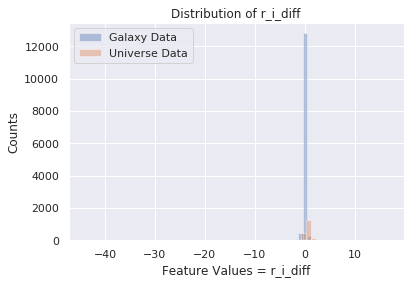

In [14]:
# Show distribution of values for each feature galaxy vs. universe
for i, feature in enumerate(orig_features+eng_features):
    
    xg = x_train_scaled[:,i]
    xu = x_small_universe_scaled[:,i]
    
    # Plot histogram
    fig, ax = plt.subplots()
    sns.distplot(xg, label = "Galaxy Data", kde=False, ax=ax)
    sns.distplot(xu, label = "Universe Data", kde=False, ax=ax)
    plt.xlabel(f"Feature Values = {feature}")
    plt.ylabel("Counts")
    plt.title(f"Distribution of {feature}")
    plt.legend()

### Predict again

In [15]:
# Create predictions from new universe data using model trained on galaxy data
predictions = model.predict(x_small_universe_scaled)
predictions_df = pd.DataFrame(predictions, columns = ["prob_0", "prob_1"])
predictions_df["Elliptical"] = predictions_df["prob_1"].apply(lambda x: 1 if x > .5 else 0)

# Print portion of universe data predicted to be elliptical
n_predict_e = predictions_df[predictions_df["Elliptical"]==1].Elliptical.count()
n_predict_non_e = predictions_df[predictions_df["Elliptical"]==0].Elliptical.count()
print(f"% Ellip Predicted in (small) Universe= {(n_predict_e/(n_predict_e+n_predict_non_e)):3.2}")

% Ellip Predicted in (small) Universe= 0.91


**STUDENT COMMENTARY:**

- In the above cells, we eliminate observations from the universe where the red or green color values for the universe are more than 2.5 sd beyond the mean of the galaxy data.
- This adjustment to the universe data has brought the percentage of ellipticals predicted in the unverse down.  But, it also dropped a large number of observations for which feature values differed the most with feature values in our galaxy training data.

# Q3.3:  OTHER PROPOSALS

### Look at distribution of feature values for labeled universe data vs. full universe vs. galaxy

In [16]:
# Look at only labeled rows in universe by dropping labels=NaN
universe_labeled=universe_df.dropna()

# Create DF with just features
x_universe_labeled = universe_labeled[orig_features+eng_features] 

# Convert x into scaled numpy array using original scaler from training
x_universe_labeled_scaled = scaler.transform(x_universe_labeled.astype(np.float64))

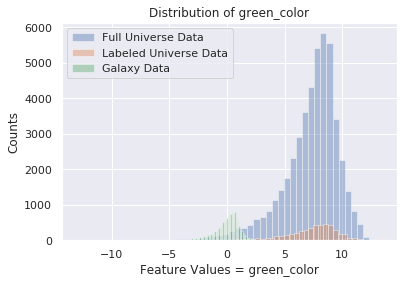

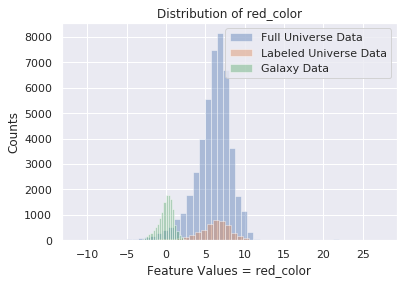

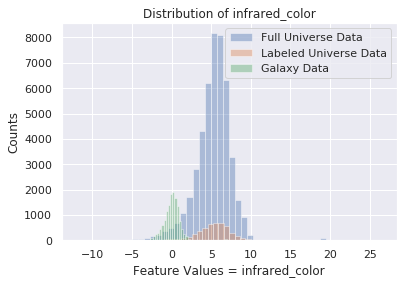

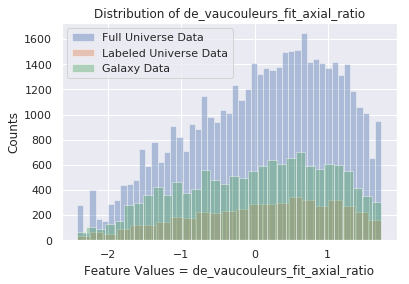

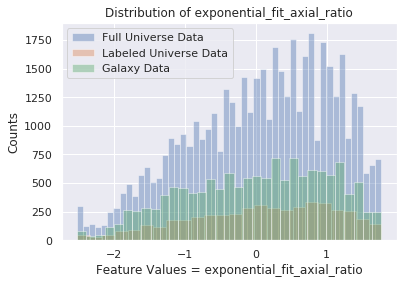

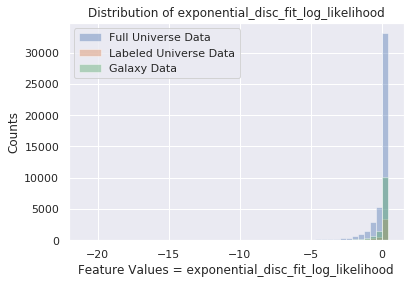

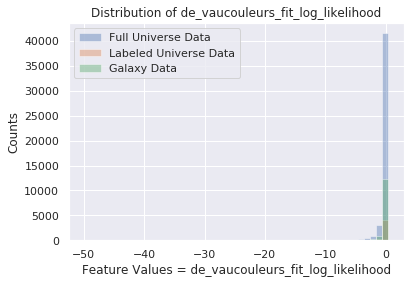

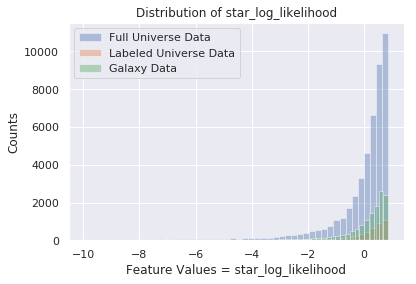

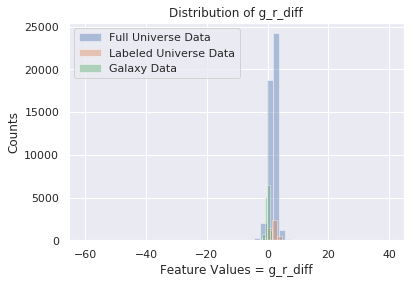

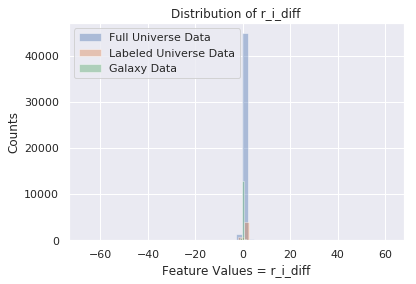

In [17]:
# Show distribution of values for each feature labeled universe vs. total universe
for i, feature in enumerate(orig_features+eng_features):
    
    xu = x_universe_scaled[:,i]
    xul = x_universe_labeled_scaled[:,i]
    xg = x_train_scaled[:,i]
    
    # Plot histogram
    fig, ax = plt.subplots()
    sns.distplot(xu, label = "Full Universe Data", kde=False, ax=ax)
    sns.distplot(xul, label = "Labeled Universe Data", kde=False, ax=ax)
    sns.distplot(xg, label = "Galaxy Data", kde=False, ax=ax)
    plt.xlabel(f"Feature Values = {feature}")
    plt.ylabel("Counts")
    plt.title(f"Distribution of {feature}")
    plt.legend()

**STUDENT COMMENTARY:**

The root of the problem is that the data for the universe has feature values that differ meaningfully in both mean and variance from the feature values of the galaxy upon which we trained.  To the extent there is a relationship between the feature values and the classification labels, our model does not know what that relationship is.  We can simply make predictions for the narrow set of observations with universe feature values in the range of our training data (see Q3.2 above), but this is overly narrowing our problem.

One solution would be to collect training data from the universe and train a new model using this new training data.  The universe data we were given did have some observations with labels, so perhaps this "training on universe data" is posible.  The labeled universe training data would have to have feature values distributed in a manner similar to the universe. The analysis above of the distribution of feature values for the labeled universe vs. the full universe shows significant differences is variance (though similarity in mean).   So, the idea of using labeled universe data as training data for a new model is not promising.

Perhaps a better solution involves the following ideas, but it is hard to fully articulate:

- The charts above do show the labeled universe data has a mean similar to the mean for the full universe.

- The charts above do show the range of feature values for the full universe is closely approximated by the combination of ranges for the labeled galaxy data and the labeled universe data.

- Perhaps the 209b lecture on **Optimal Transport** would allow us to "transport" and transform the labeled data from the galaxy dataset **into** the universe dataset.  With both the labeled galaxy data (transported into universe) and the labeled universe data, we could then train a universe model